# Clustering algorithms comparison

## Index
1. [Imports](#id1)
2. [File reading](#id2)
3. [Clustering algorithms](#id3)
    1. [BIRCH](#id3.1)
    2. [DBSCAN](#id3.2)
    3. [K-means](#id3.3)
    4. [Mini-Batch K-means](#id3.4)
    5. [Mean Shift](#id3.5)
    6. [OPTICS](#id3.6)
    7. [Spectral Clustering](#id3.7)
    8. [Mixture of Gaussians](#id3.8)
    9. [Partition around medoids (PAM)](#id3.9)
    10. [UPGMA](#id3.10) 
4. [Clustering method](#id4)
5. [Quality metrics method](#id5)
6. [Visualizing a labelled dataset](#id6)
7. [Testing methods](#id7)
8. [Optimal algorithm hyperparameters.](#id8)


### 1. Imports <div id='id1'></div>

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import Birch, DBSCAN, KMeans, MiniBatchKMeans, OPTICS, MeanShift, SpectralClustering
from sklearn.cluster import estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.metrics import pairwise_distances, silhouette_score, calinski_harabasz_score, davies_bouldin_score


### 2. File reading <div id='id2'></div>

          0         1         2
0  0.912742  1.719443  1.606405
1  0.313207  1.769782  1.628300
2  1.423678 -0.713694 -0.594431
3 -0.066379  2.153243  1.963148
4  1.036332  0.658611  0.642875


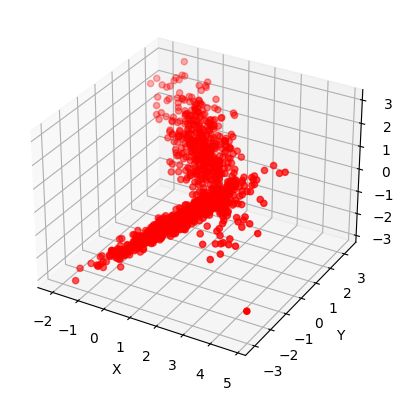

In [3]:
# read txt file
file = pd.read_csv('alvbercau_alvgonfri_dataset.txt', sep=" ", header=None)

# convert to dataframe in order to use pandas methods if needed
df = pd.DataFrame(file)

# show the first 5 rows
print(df.head())

# visualize the data with a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0], df[1], df[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# convert dataframe to numpy array
X = df.values


### 3. Clustering algorithms <div id='id3'></div>

#### BIRCH <div id='id3.1'></div>

In [4]:
def birch(data, k):
    brc = Birch(n_clusters=k).fit(data)
    labels = brc.predict(data)
    return labels

#### DBSCAN <div id='id3.2'></div>

In [5]:
def dbscan(data, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    return labels

#### K-Means <div id='id3.3'></div>

In [6]:
def kmeans(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

#### Mini-Batch K-Means <div id='id3.4'></div>

In [7]:
#Se usa para reducir el tiempo de calculo (Se suele reducir la calidad de los resultados)
def mini_batch_kmeans(data, k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=6, max_iter=10,n_init=10).fit(data)
    labels = kmeans.predict(data)
    return labels

#### Mean Shift <div id='id3.5'></div>

In [8]:
# parameters quantile and n_samples are used to estimate the bandwidth, which is the hyperparameter of Mean Shift
def mean_shift(data, quantile, n_samples):
    bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=n_samples)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(data)
    labels = ms.labels_
    return labels

#### OPTICS <div id='id3.6'></div>

In [9]:
def optics(data, eps, min_samples):
    db = OPTICS(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    return labels

#### Spectral Clustering <div id='id3.7'></div>

In [10]:
def spectral_clustering(data, k):
    sc = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=0).fit(data)
    labels = sc.labels_
    return labels

#### Mixture of Gaussians <div id='id3.8'></div>

In [11]:
def gaussian_mixture(data, k):
    gmm = GaussianMixture(n_components=k).fit(data)
    labels = gmm.predict(data)
    return labels

#### Partition around medoids (PAM) <div id= 'id3.9'></div>

In [12]:
def pam(X, n_clusters, max_iterations=100):
    # Initialize medoids randomly
    medoids = np.random.choice(range(X.shape[0]), size=n_clusters, replace=False)
    current_medoids = np.copy(medoids)

    for _ in range(max_iterations):
        # Assign each data point to the nearest medoid
        labels = assign_points_to_medoids(X, current_medoids)

        # Update the medoids by computing the total distance within each cluster
        for cluster_id in range(n_clusters):
            cluster_points = X[labels == cluster_id]
            medoid_id = np.argmin(np.sum(cdist(cluster_points, cluster_points, metric='cityblock'), axis=1))
            current_medoids[cluster_id] = np.where(labels == cluster_id)[0][medoid_id] 

        # If the medoids have not changed, terminate the algorithm
        if np.array_equal(medoids, current_medoids):
            break

        medoids = np.copy(current_medoids)

    return labels


def assign_points_to_medoids(X, medoids):
    distance_matrix = np.zeros((X.shape[0], len(medoids)))
    for i, medoid in enumerate(medoids):
        distance_matrix[:, i] = np.sum(np.abs(X - X[medoid]), axis=1)
    return np.argmin(distance_matrix, axis=1)

#### UPGMA <div id='id3.10'></div>

In [36]:
def upgma(data, num_clusters, max_iterations=100):
    # Step 1: Create a distance matrix
    distance_matrix = pairwise_distances(data, metric='euclidean')
    np.fill_diagonal(distance_matrix, np.inf)  # Fill diagonal with infinity

    # Step 2: Create a dictionary to store the cluster labels and distances
    clusters = {i: [i] for i in range(data.shape[0])}
    distances = {i: 0 for i in range(data.shape[0])}

    # Step 3: Perform clustering
    for iteration in range(max_iterations):
        # Find the minimum distance in the distance matrix
        min_distance = np.min(distance_matrix)
        if min_distance == np.inf:
            break  # Terminate the loop if the minimum distance is infinity

        # Find the indices of the two clusters with the minimum distance
        cluster_indices = np.where(distance_matrix == min_distance)
        cluster1, cluster2 = cluster_indices[0][0], cluster_indices[1][0]

        # Merge the two clusters
        new_cluster = clusters[cluster1] + clusters[cluster2]
        clusters[data.shape[0] + iteration] = new_cluster

        # Update the distance matrix
        for cluster in clusters:
            if cluster != cluster1 and cluster != cluster2:
                avg_distance = (distances[cluster1] * len(clusters[cluster1]) +
                                distances[cluster2] * len(clusters[cluster2])) / (len(clusters[cluster1]) +
                                                                                 len(clusters[cluster2]))
                distances[cluster] = avg_distance

        # Set the merged clusters' distances to infinity in the distance matrix
        distance_matrix[cluster1, :] = np.inf
        distance_matrix[cluster2, :] = np.inf
        distance_matrix[:, cluster1] = np.inf
        distance_matrix[:, cluster2] = np.inf

    # Step 4: Assign cluster labels to the original data points
    labels = np.zeros(data.shape[0], dtype=int)
    for cluster_id, cluster in enumerate(clusters.values()):
        if cluster_id < num_clusters:
            for sample_id in cluster:
                labels[sample_id] = cluster_id
        else:
            for sample_id in cluster:
                labels[sample_id] = 0

    # Step 5: Create a Pandas DataFrame for the clusters
    result = pd.DataFrame(data=data, columns=['x', 'y', 'z'])
    result['Cluster'] = labels

    return result['Cluster'].values


In [87]:
def UPGMA(data, k):
   # Calcula las distancias utilizando la métrica euclidiana
    distances = pdist(data, metric='euclidean')

    # Calcula la matriz de enlace utilizando UPGMA
    Z = linkage(distances, method='average')

    # Realiza la asignación de clústeres utilizando la función fcluster
    labels = fcluster(Z, k, criterion='maxclust')

    return labels


### 4. Clustering method <div id='id4'></div>

In [85]:
def clustering(data, algorithm, hyperparameters):
    if algorithm == 'birch':
        return birch(data, hyperparameters.get('k'))
    elif algorithm == 'dbscan':
        return dbscan(data,  hyperparameters.get('eps'),  hyperparameters.get('min_samples'))
    elif algorithm == 'kmeans':
        return kmeans(data, hyperparameters.get('k'))
    elif algorithm == 'mini_batch_kmeans':
        return mini_batch_kmeans(data, hyperparameters.get('k'))
    elif algorithm == 'mean_shift':
        return mean_shift(data, hyperparameters.get('quantile'),  hyperparameters.get('n_samples'))
    elif algorithm == 'optics':
        return optics(data, hyperparameters.get('eps'),  hyperparameters.get('min_samples'))
    elif algorithm == 'spectral_clustering':
        return spectral_clustering(data, hyperparameters.get('k'))
    elif algorithm == 'mixture_of_gaussians':
        return gaussian_mixture(data, hyperparameters.get('k'))
    elif algorithm == 'partition_around_medoids':
        return pam(data, hyperparameters.get('k'))
    elif algorithm == 'upgma':
        return UPGMA(data, hyperparameters.get('k'))       
    else:
        print("Not valid algorithm")

### 5. Quality metrics method <div id='id5'></div>

In [15]:
def get_quality_metric(data, labels, metric):
    if metric == 'silhouette':
        return None
    elif metric == 'davies_bouldin':
        return None
    elif metric == 'calinski_harabasz':
        return None
    else:
        print("Not valid metric")


### 6. Visualizing a labelled dataset <div id='id6'></div>

In [16]:
def visualize_labelled_dataset(data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

### 7. Testing methods <div id = 'id7'></div>

The methods defined above are tested with the different clustering algorithms.

#### BIRCH

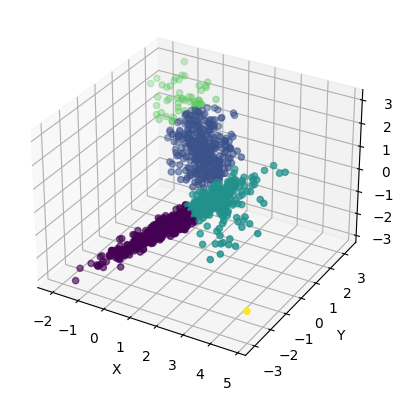

In [17]:
# Birch with 5 clusters
labels = clustering(X, 'birch', {'k': 5})
#print(labels)
visualize_labelled_dataset(X, labels)

#### DBSCAN

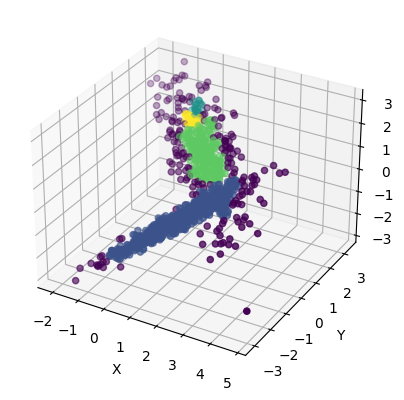

In [18]:
# dbscan 

#labels = clustering(X, 'dbscan', {'eps': 0.15, 'min_samples': 10})
labels = clustering(X, 'dbscan', {'eps': 0.2, 'min_samples': 10})
#labels = clustering(X, 'dbscan', {'eps': 0.2, 'min_samples': 20}) # variamos el número minimo de puntos para que sea considerado un cluster
#labels = clustering(X, 'dbscan', {'eps': 0.25, 'min_samples': 20})
#labels = clustering(X, 'dbscan', {'eps': 0.6, 'min_samples': 100})
#print(labels)
visualize_labelled_dataset(X, labels)

#### K-Means

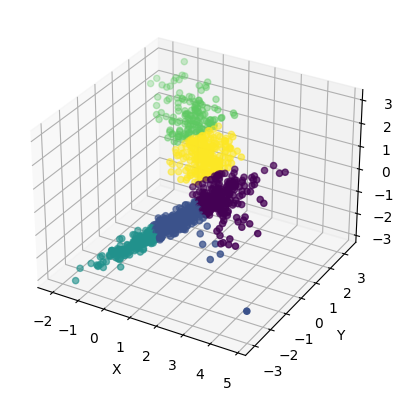

In [19]:
# kmeans with 5 clusters
labels = clustering(X, 'kmeans', {'k': 5})
# print(labels)
visualize_labelled_dataset(X, labels)

#### Mini-Batch K-Means

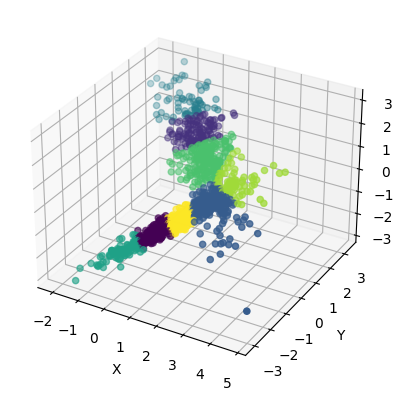

In [20]:
# Mini-batch kmeans with 15 clusters
labels = clustering(X, 'mini_batch_kmeans', {'k': 8})
# print(labels)
visualize_labelled_dataset(X, labels)

#### Mean Shift

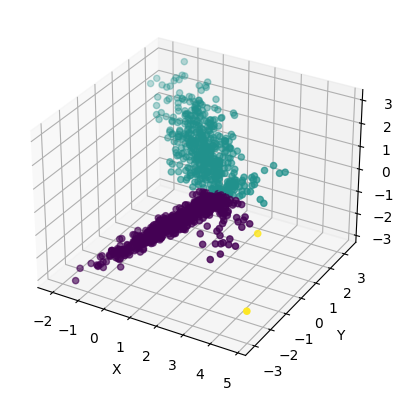

In [21]:
# Mean Shift with quantile=0.2 and n_samples=500
labels = clustering(X, 'mean_shift', {'quantile': 0.2, 'n_samples': 500})
# print(labels)
visualize_labelled_dataset(X, labels)

#### OPTICS

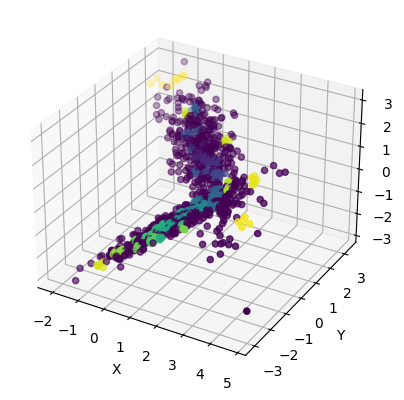

In [22]:
# optics
labels = clustering(X, 'optics', {'eps': 0.75, 'min_samples': 5})
#print(labels)
visualize_labelled_dataset(X, labels)

#### Spectral Clustering

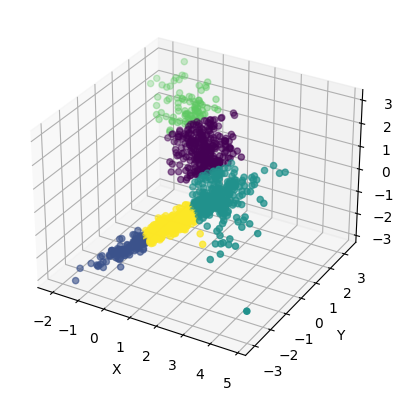

In [23]:
# Spectral Clustering with 5 clusters
labels = clustering(X, 'spectral_clustering', {'k': 5})
# print(labels)
visualize_labelled_dataset(X, labels)

#### Mixture of Gaussians

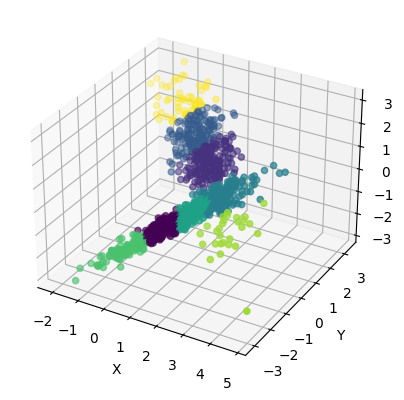

In [24]:
# Mixture of Gaussians with 8 clusters
labels = clustering(X, 'mixture_of_gaussians', {'k': 8})
# print(labels)
visualize_labelled_dataset(X, labels)

#### Partition around medoids (PAM)

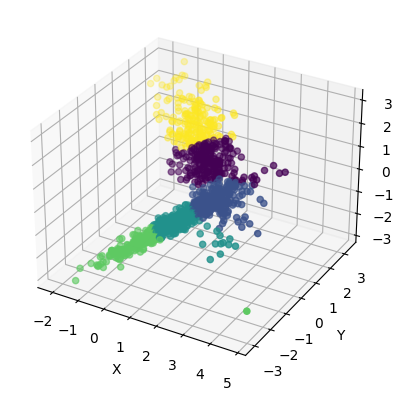

In [25]:
# Partition Around Medoids with 5 clusters
labels = clustering(X, 'partition_around_medoids', {'k': 5})
visualize_labelled_dataset(X, labels)

#### UPGMA

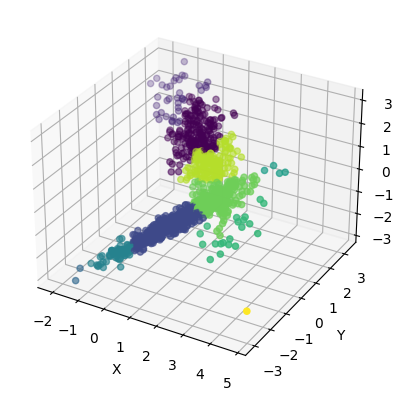

In [89]:
# UPGMA with 10
labels = clustering(X, 'upgma', {'k': 10})
print(labels)
visualize_labelled_dataset(X, labels)

### 8. Optimal algorithm hyperparameters <div id = 'id8'></div>

In [27]:
#Create a method that for each algorithm  returns the name of the algorithm and the hyperparameters that best fit the data
def get_best_hyperparameters(data, metric, hyperparameters):
    if metric == 'silhouette':
        return None
    elif metric == 'davies_bouldin':
        return None
    elif metric == 'calinski_harabasz':
        return None
    else:
        print("Not valid metric")
